# SESSION 1: NEURAL NETWORKS FUNDAMENTALS

SO Basics of Neural Networks 2025 school at the IAA-CSIC. Oct 2025.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
Dept. of CS and Artificial Intelligence. University of Seville. Spain.  


### 1. Introduction

In this notebook we are going to take our first steps into the implementation of neural networks. Nowadays, there are two main neural networks frameworks:
* Tensorflow (TF), developed by Google.
* Pytorch, TF's main competitor, released by Facebook (Meta).

TF has been selected for this session, due to the simplicity of versions >= 2.0 (released in 2019). Particularly, its integration with Keras has significantly simplified neural networks definition. It is also the default frameworks in industrial and enterprise environments.

In any case, all concepts and techniques we will learn in these sessions can be directly applied to Pytorch. At user level, once dominated the core concepts of TF, it is extremely easy to migrate to another frameworks with a very smooth learning curve.

Tensorflow was developed by Google Brain for internal purposes and was open sourced in 2015. Since then, it has evolved up to its current version TF2.20. There are two main APIs:

*   High-level (tf.keras): it is enough for user level normal applications.
*   Lower-level (python API): adds a finer control of all neural network "operations", custom loss functions, metrics, initializers, etc. Even training loop technical details can be controlled.

<br>

![picture](https://drive.google.com/uc?id=1ZzkQ_zHt2VMc_zgqFTI50jd_iG0LsQeI)


### 2. Dataset

Some datasets have become the de facto benchmarck to compare different deep learning models performance. For image classification, the classical ones are:

* **MNIST dataset**, composed by hand-written digits from 0-9. Grayscale 28x28 images and 10 classes.

<br>

![picture](https://drive.google.com/uc?id=1DvG19JZ8RfMwF1MRJns_GbXjFnJQmYAE)

<br>

* **Fashion-MNIST dataset**, once NN classification models improved their performance, a more difficult benchmark dataset was needed. Zalando proposed a new one called Fashion-MNIST as a direct drop-in replacement for the original MNIST dataset. It is based on Zalando`s article images with grayscale 28x28 images and 10 classes.

<br>

![picture](https://drive.google.com/uc?id=1SKvSSdyHN6FrORpIO4km_aMCo33AouNf)

<br>

* Other field-specific datasets have been proposed:
   - Galaxy10: composed by colored galaxy images from 10 classes, 69x69 RGB.

For educational purposes, in this first session we will tackle a multiclass classification problem (dataset: Fashion-MNIST dataset). In this first step the selected architecture is a basic multilayer structure: MLP (Multilayer Perceptron). While solving this problem key concepts about neural networks will be explained as: training, backpropagation, loss function, etc. In the hands-on session, the techniques presented in this notebook will be used to tackle the Galaxy10 classification problem.

### 3. Loading data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
tf.__version__
# 2.14.0

'2.19.0'

For reproducibility purposes, a seed if provided to the system. This seed has to be fixed separately in Python, numpy and Tensorflow. Luckily, in recent versions of TF a new functionality has been added fixing all seeds in one single step. Of course, the seed value can be set to any integer value but for sentimental reasons 42 is the most common seed.  

The community believes the origin for this concrete seed value is in Douglas Adams’s science-fiction novel: *The Hitchhiker’s Guide to the Galaxy* (1979). Towards the end of the book, the supercomputer Deep Thought revealed that the answer to the great question of “life, the universe and everything” is 42.

In [3]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# this utility is equivalent to the following
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

All frameworks have functionalities to load easily reference datasets as fashion-MNIST. All these functions are collected in a library typically called `datasets`. (https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Loading a dataset means, to obtain one or multiple numpy arrays containing the input atributes $(X)$ and its associated labels $(y)$. Depending on the concrete framework/dataset, the obtained info can be either divided into train and test datasets or not. Sometimes it can be a little bit tricky. For instance, the Fashion-MNIST is obtained from:
* tensorflow: as 28x28 numpy arrays.
* scikit-learn: as 1D array of length 784.

In our Fashion-MNIST dataset, TF provides two datasets and its associated class labels:

* Train dataset: $X_{train\_full}$ (60K samples)
* Test dataset: $X_{test}$ (10K samples)

Inspecting their shapes, we can confirm their dimensions: 28x28 pixeles. Additionally, from the shape we can deduce that they are grayscale (not colored) images.

In [5]:
print("training dataset: ", X_train_full.shape)
print("test dataset: ", X_test.shape)

training dataset:  (60000, 28, 28)
test dataset:  (10000, 28, 28)


Colored images have an additional "axis" indicating the number of channels (colors), something like this: `(60000, 28, 28, 3)`.

Let's visualize a few examples from the training set to get a feel for the data. Each image is a 28x28 grayscale image of a piece of clothing."

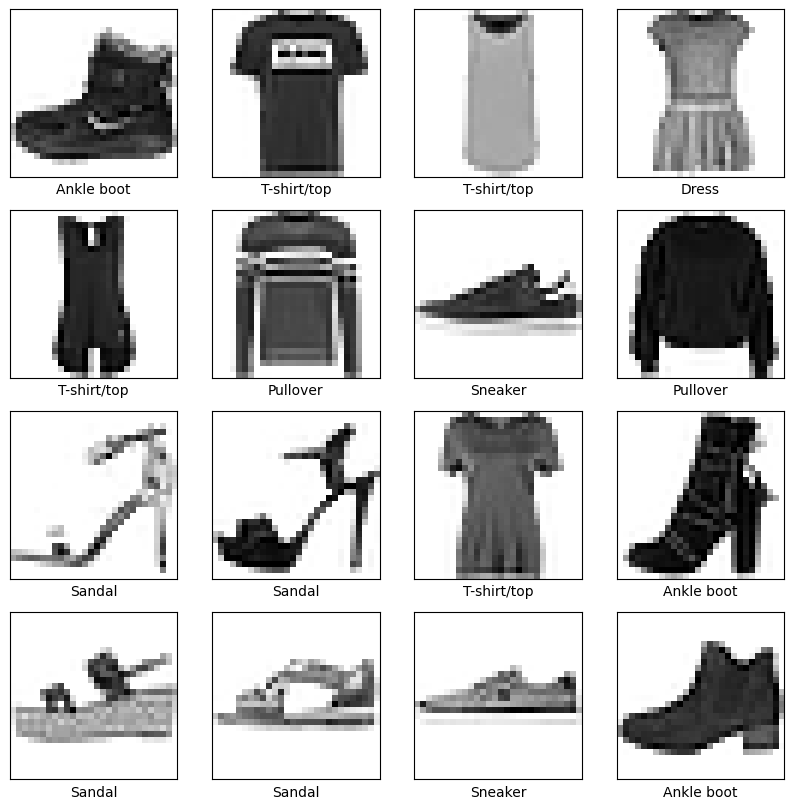

In [6]:
import matplotlib.pyplot as plt

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_full[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_full[i]])

### 4. Data preprocessing

At this stage we have a train and a test dataset. But in neural networks, a third *validation* dataset is needed to check how model performance progress during training. In this case, we have decided to select randomly 5K from the original 60K training dataset.

One of the advantages of neural networks is their intrinsic ability to perform "feature extraction" as part of the training pipeline. Hence, a human intervention is not needed to identify the most relevant features. For this reason, the preprocessing of images feeded to the networks is very simple.


The range of values $[0,255]$ contained in the matrix can be problematic when gradient descent is involved. We can check the maximum and minimum values of the image pixels and their data type (unsigned integer):

In [7]:
np.min(X_train_full), np.max(X_train_full), X_train_full.dtype

(np.uint8(0), np.uint8(255), dtype('uint8'))

There are different strategies to scale input "atributes". The most widely used is simply, to divide by $255.0$, compressing the values into the range $[0,1]$.

Both steps, the creation of the validation dataset $X\_valid$, and the pixel scaling can be performed in a single step.

Do not forget to scale the test data as well!

In [8]:
X_valid, X_train, X_test = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0, X_test/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [9]:
assert X_valid.shape == (5000,28,28)
assert X_train.shape == (55000,28,28)

### 5. Model architecture

In order to learn multiple basic concepts about neural networks, we will tackle this classification problem with a MLP architecture. At this point, some design decisions must be taken about our MLP netowrk:
* The layer structure.
* Number of neurons of each layer and their activation function.

![picture](https://drive.google.com/uc?id=1caBJEFAB3hIKfX9zZTMsZVgl4FcHfNW9)




### 5.1. Input layer

NNs always have a first layer called input layer acting as a host or entry-point to the network.It receives input samples and provides the arrays to the rest of the network informing the rest of the network about the input shape. It acts simply as a __passthrough layer__ with no activation function associated.
(https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)

In [10]:
input_layer = tf.keras.layers.InputLayer(shape=[28, 28], name='input_layer')

### 5.2. Flattening layer

In image problems, input samples are 2D-arrays where each pixel is a feature. Unfortunately, hidden __dense layers can only handle 1D-arrays__. Thus, the image must __flatten the 2D-array__ converting it into a 1D vector. In our case, the 28x28 arrays must be flattened into 1D-array with length 28x28 = 784. Hence, depending on the input array shape, a transformation could be needed. A layer called _Flatten_ is needed.
(https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

Once performed the flattening, we obtain a 1D input array of size 784.

In [11]:
flatten_layer = tf.keras.layers.Flatten(name='flatten_layer')

### 5.2. Output layer


The output layer is a common dense layer but its parameters (number of neurons and activation function) depend strongly on the task we are tackling. For a basic classification problem there are two possibilities: binary classification and multiclass classification.

__Binary classification__:  

 - Each class is labeled as 0 or 1.
 - Hence, only 1 neuron is needed.
 - The desired interpretation to this neuron output:
 $$A_{output} = P(Y=1)$$   
 - The activation function that provides this functionality is the sigmoid.

 $$\sigma(z) = \frac{1}{1+e^{-z}}$$


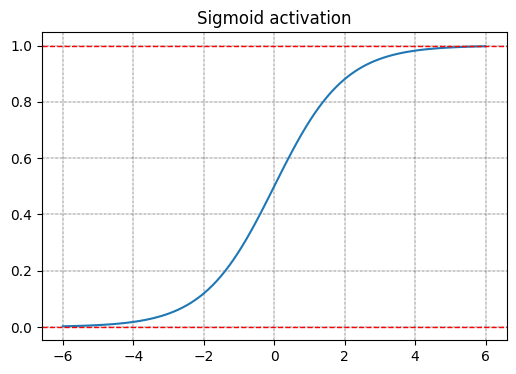

In [12]:
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1/(1 + np.exp(-x))

x = np.linspace(-6, 6, 100)

plt.figure(figsize=(6, 4))
plt.plot(x, sigmoid(x))
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.axhline(y=1, color='r', linestyle='--', linewidth=1)
plt.title("Sigmoid activation")
plt.grid(color='black', linestyle='-.', linewidth=0.3)

__Multiclass classification__:

 - As many labels as classes.
 - Hence, #neurons = #classes.
 - The desired intepretation of each output neuron _i_ is:
 $$A_{output} = P(Y=i)$$   
   with:
 $$\sum_{i=1}^{n} A_{output} = \sum_{i=1}^{n} P(Y=i)= 1$$  
 <br>

 - The activation function that provides this functionality is the softmax.

 $$softmax(z) = \frac{e^{z_i}}{\sum_{i=1}^{n}e^{z_i}}$$

In [13]:
num_classes = 10
output_layer = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')

### 5.3. Hidden layers

### 5.3.1. How many layers?

As we have seen previously, in image classification problems each pixel is a feature. As a consequence, input samples have a huge dimensionality. This implies that the network needs to "travel" from 784-d image representations to 10-d. The typical structure used in these cases are a dimensionality descending strategies:

<br>

![picture](https://drive.google.com/uc?id=1_tufzLQC6SYW40NOAiGWMYD3MlLdP1Vj)

The number of hidden layers depends on each problem and it is usually determined with heuristic criteria. To help the network perform these transformations, we have decided to include two hidden layers in the model (with 300 and 100 neurons, respectively).



### 5.3.2. Activation function selection

Next, we have to decide the activation function associated to these layers.
Probably you expect that the standard activation is the sigmoid but ...

After Rumelhart (backpropagation + Gradiente descent + Sigmoid) proposal in 1986, a new hype begun. Many researchers run to apply this novel technique to train multilayer models. Soon, new unexpected problems appeared during training:

* Gradient vanishing: only the layers nearer to the output get trained.
* Slow training.  

The source of these problems remained unknown until Glorot & Bengio published an extremely important paper: [Glorot and Bengio. Understanding the difficulty of training deep feedforward networks (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). One of their main proposal for solving these problems was to avoid using the so called s-shape activation functions:

* sigmoid
* tanh

A new activation layer was proposed: ReLU (Rectified Linear Unit)

<br>

![picture](https://drive.google.com/uc?id=1_kwopQLyHjAq7laRcVsJop8DAmuLPlbP)


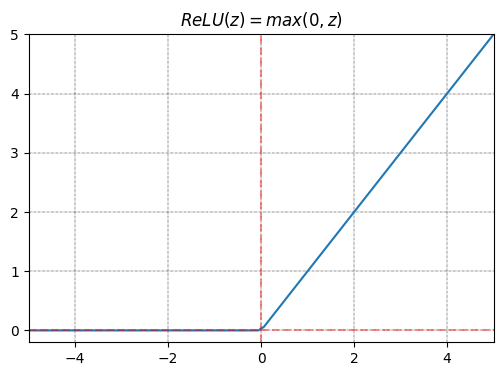

In [14]:
def relu(z: np.ndarray):
    z = z.reshape(-1,1)
    return np.apply_along_axis(func1d=lambda x: x if x>=0.0 else 0.0, axis=1, arr=z)

x = np.linspace(-6, 6, 100)

plt.figure(figsize=(6, 4))
plt.plot(x, relu(x))
plt.grid(color='black', linestyle='-.', linewidth=0.3)
plt.axhline(y=0,color='red', linestyle='--',alpha=0.4)
plt.axvline(x=0,color='red', linestyle='--',alpha=0.4)
plt.xlim(-5,5)
plt.ylim(-0.2,5)
plt.title('$ReLU(z) = max(0,z)$');


Activation functions is still an active research area. Many improvements of this basic ReLU have been proposed, relaxing different zones of the curve:

* **LeakyReLU**: constant negative slope for x < 0
* **Exponential ReLU** (ELU)
* **Scaled ELU** (SELU)

/tmp/ipython-input-2072967239.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.apply_along_axis(func1d=lambda x: alpha*(math.exp(x)-1) if x<0.0 else x,


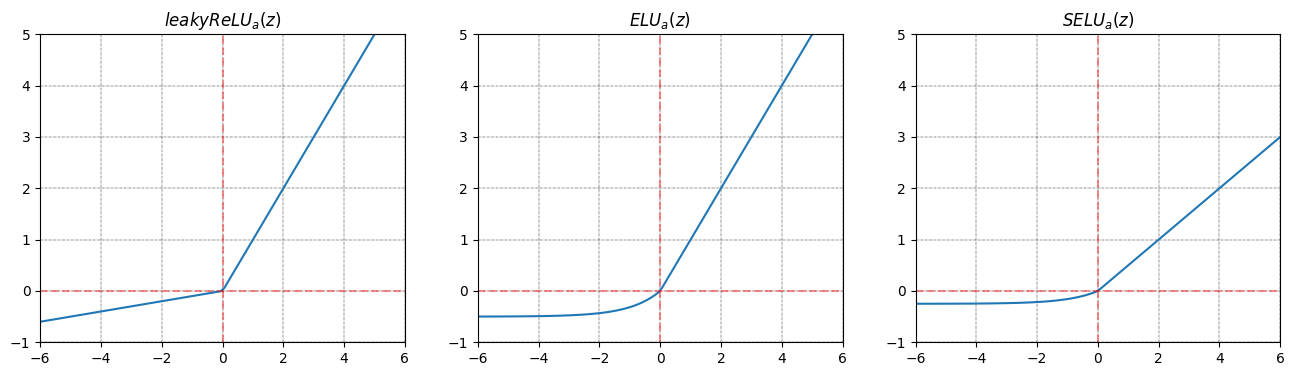

In [15]:
import math

def leakyReLu(z: np.ndarray):
    z = z.reshape(-1,1)
    return np.apply_along_axis(func1d=lambda x: x if x>=0.0 else 0.1*x, axis=1, arr=z).reshape(-1)

def elu(z: np.ndarray, alpha=0.5):
    z = z.reshape(-1,1)
    return np.apply_along_axis(func1d=lambda x: alpha*(math.exp(x)-1) if x<0.0 else x,
                               axis=1, arr=z).reshape(-1)

def selu(z: np.ndarray, alpha=0.5, scale=0.5):
    return scale*elu(z, alpha)

afs = [leakyReLu, elu, selu]
titles = ['$leakyReLU_{a}(z)$', '$ELU_{a}(z)$', '$SELU_{a}(z)$']

x = np.linspace(-6, 6, 100)

_, axs = plt.subplots(1,3, figsize=(16, 4))
axs = axs.reshape(-1)

for k, (af, title) in enumerate(zip(afs, titles)):
    axs[k].plot(x, af(x))
    axs[k].grid(color='black', linestyle='-.', linewidth=0.3)
    axs[k].axhline(y=0,color='red', linestyle='--',alpha=0.4)
    axs[k].axvline(x=0,color='red', linestyle='--',alpha=0.4)
    axs[k].set_xlim(-6,6)
    axs[k].set_ylim(-1,5)
    axs[k].set_title(title);

The default activation function used for hidden layer is one of the ReLU family. The concrete selection depends of each situation.

### 5.4. Join all layers together

Now, we have all the ingredients to define our hidden layers:

In [16]:
hidden_1 = tf.keras.layers.Dense(300,activation='relu',name='hidden_1')
hidden_2 = tf.keras.layers.Dense(100,activation='relu',name='hidden_2')

There are two main ways of defining models in NN frameworks. In this session we use the simplest one: the so called `sequential API` or sequential definition of networks. It simply considers the network as a list of sequentially connected layers. (https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Firstly, an empty Sequential model is defined (we can imagine it as an empty list of layers), and later previously created layer will be added to the "list".

In [17]:
# First method: define layers and then add one by one
model = tf.keras.models.Sequential()

model.add(input_layer)
model.add(flatten_layer)
model.add(hidden_1)
model.add(hidden_2)
model.add(output_layer)

In [18]:
# Second method: a cleaner way, to pass layers as a list directly to the constructor
model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(shape=[28, 28], name='input_layer'),
                                    tf.keras.layers.Flatten(name='flatten_layer'),
                                    tf.keras.layers.Dense(300,activation='relu',name='hidden_1'),
                                    tf.keras.layers.Dense(100,activation='relu',name='hidden_2'),
                                    tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')])

### 5.5. Model summary & number of parameters

A description of the model can be obtained using `summary`. It shows the type, dimensionality and #params of each layer.

*   input/flattened layer: 0. The input layer has no parameters
*   hidden_1: 784 x 300 = 235.200 + bias (300) = 235.500
*   hidden_2: 300 x 100 = 30.000 + bias (100) = 30.100
*   output_layer: 100 x 10 = 1000 + bias (10) = 1.010

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_layer (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### 6. Model training: loss function

In our classification problem, the fashion-MNIST dataset can be seen as a set of $m$ tuples $(x^{i},y^{i})$:

$ \{(x^{i},y^{i}), i=1,...,m\} $

where:
* $x^{i}$ is the image i (also known as feature vector).
* $y^{i}$ is the class associated to image i (also called label).

Once selected the MLP architecture to solve the problem:
* Number of layers.
* Number of neurons per layer.
* Activation functions.

The following step is to fix the weights $W^{[i]}$ of each layer i. More formally, the parameters of the model: $θ = W^{[i]}, i = 1,...,n$.

Given an input image $x^{i}$, our model will predict a label $\hat{y}^{i}$. Our goal is to select the weights in such a way that some measure of "distance" or "difference" between $\hat{y}^{i}$ (true label) and $y^{i}$ (predicted label) is minimized. **This process is known as model training.**

These measures of distance between the predicted labels and true labels are called **"loss functions"**. This loss function depends on the concrete image problem to be tackled:

<br>

| Image problem | loss function |
| :- | :- |
| Image classification | Crossentropy |
| Image location | Interesection-over-union (IoU) |
| Object detection | Mean average precision (mAP) |
| Image segmentation | Pixel-wise crossentropy |

<br>

**Crossentropy** is, by far, the most popular loss function in classification problems. As we know, the output value of each neuron $i$ in the output layer can be interpreted as the probability of image to belongs to each class $i$. For the simplest situation with 2 classes:

<br>

$J = \frac{1}{m} \sum_{i=1}^{m}[y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)})log(1-\hat{y}^{(i)})]$

<br>

When the number of classes > 2, the previous expression can be generalized and  a  `categorical_crossentropy` is considered.

The graphical representation in a 2 classes problem:

![picture](https://drive.google.com/uc?id=16JxCGImeBJAKX1-wpUhgjigZL7DLC7ZZ)

Our goal is to minimize this loss function. The different losses can be found in  https://keras.io/api/losses/ y https://www.tensorflow.org/api_docs/python/tf/keras/losses.






### 7. Model training: backpropagation

As seen in the previous section, our model has aprox. 266K parameters (weights):

$$\text{loss function} = \text{crossentropy} = f(weights)$$

Hence, to train the model means to find a concrete value for each of these 266K weights. Or equivalently, a point in a 266K-dimension space. As you can imagine, this is a complex problem.

Even worse, due to the presence of non-linear activation functions, crossentropy is not a convex curve. Unfortunately, there is no analitical way to obtain the global minimum of a 266K dimension non-convex function. So, numerical techniques must be considered to find them:

* On the left, a typical convex 2-d loss function.  
* On the right, a complex loss function

<br>

![picture](https://drive.google.com/uc?id=1WneAL6O_PjFTg_FUTzMpMHxVnPKT9u2B)

 This numerical technique remained unknown during almost 20 years until Rumelhart proposed: backpropagation + gradient descent. Roughly speaking this technique has three steps:

* Forward pass: given an input image, the error between the true label and the predicted one is obtained ($J$).
* Backward pass: using the derivative chain rule, the previous error is "backpropagated", and the contribution of each weight to this error can be obtained.

$$\nabla{J} = \frac{∂J}{∂W_{i}}$$

* Gradient descent: a slight variation in the weights is performed based on the gradient. This variation is controlled by a parameter known as **learning rate**. Typical values in image classification problems are in the range (1e-3, 1e-4).

$$\Delta{W} = -\eta\nabla{J}$$

As mentioned earlier, when Rumelhart proposal was used in real models, multiple unexpected problems appeared. Some of the problems were solved migrating from s-shape to ReLU activation functions. Unfortunately, a second huge problem remained: **gradient descent is a slow technique**. To manage this disadvantage several alternatives have been proposed and are available in the different frameworks.

Some of these improved optimization techniques alter the learning rate during the process, while others maintaining a registry of the previously visited gradients to take decision during the optimization process. In the following table a summary of the different techniques is presented:

<br>

![picture](https://drive.google.com/uc?id=1mlGacEAlwORodteX7duxz2081ZUNCcdT)

<br>

Typically an adam optimizer is considered in NN training https://www.tensorflow.org/api_docs/python/tf/keras/optimizers.

All these information must be provided to the model using the `compile` method.


We use `sparse_categorical_crossentropy` because our labels (`y_train`) are provided as single integers (0,1,2, etc.). If our labels were one-hot encoded (e.g. [0,0,1,0,0,0,0,0,0,0] for class 2), we would use `categorical_crossentropy`.

In [20]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 8. Model training

**Epochs**

NN models are trained on our training dataset but why not use it as many times as it is useful. The concept of `EPOCH` captures the idea of using the dataset multiple times to train the model. e.g. 10 epochs means, use 10 times the dataset during the training process.

**Validation dataset**

When a model is trained multiple times using the same dataset, an undesiderable phenomenon appears: `overfitting`. Overfitting will be explained in more details in the following sessions. Briefly, it means that our models "remember" our dataset losing its generalization capacity.

So the ideal situation is to train the model during as many EPOCHS as possible but stopping before overfitting appears. To determine if this point has been reached or not during training needs a third dataset: the validation dataset.

Then, a NN model training involves three datasets:

* train dataset: the model is trained considering only this dataset. As many EPOCHS as possible.
* validation dataset: after each epoch typically the loss and accuracy is calculated on this validation dataset. If a degradation in this loss appears, it is interpreted as overfitting.
* test dataset: is only considered when training has finished.

**Training history**

Typically, the training process `history` can be recorded for further analysis.


**Verbosity**

In general, verbosity is a concept related with the amount of information provided by a "program" during its operation. In NN training, verbosity is an argument to the training method:
* verbose = 0: no info is provided to the user.
* verbose = 1 (default value): accuracy and loss after each epoch is provided to the user.  

The time taken by this process depends on our hardware. In case of having a CPU, it will take longer than when using a hardware accelerator as a GPU (Graphics Processing Unit) or a TPU (Tensor Processing Unit).

The Fashion-MNIST dataset is quite small and shapes are easily identified by the networks. It can be run on GPU or CPU.

In [21]:
EPOCHS = 10
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7816 - loss: 0.6103 - val_accuracy: 0.8614 - val_loss: 0.3752
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8602 - loss: 0.3772 - val_accuracy: 0.8728 - val_loss: 0.3451
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8773 - loss: 0.3316 - val_accuracy: 0.8724 - val_loss: 0.3556
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8877 - loss: 0.3034 - val_accuracy: 0.8810 - val_loss: 0.3270
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8944 - loss: 0.2847 - val_accuracy: 0.8890 - val_loss: 0.3221
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9009 - loss: 0.2668 - val_accuracy: 0.8846 - val_loss: 0.3343
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9043 - loss: 0.2546 - val_accuracy: 0.8956 - val_loss: 0.3079
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9097 - loss: 0

The training history is usually plotted to compare the evolution of train and validation datasets. The minimum value of loss is reached after 4 epochs. Once reached this point, loss starts growing and training should have been stopped. In the following sessions, the stopping procedure will be explained.

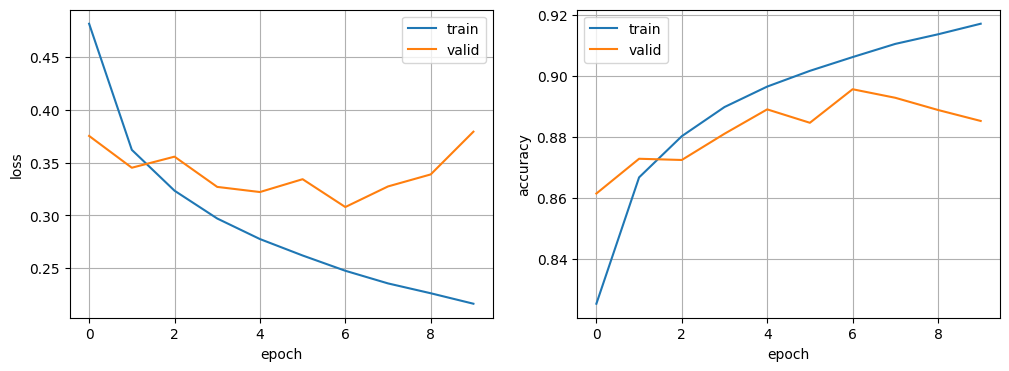

In [22]:
df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();



To obtain the model performance, the `evaluate` method is used on the test dataset:

In [23]:
res = model.evaluate(X_test,y_test, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.88


#### 9. Using the model

Do not forget we have train the model to make predictions on new images. Given an input image, the `predict` method returns the output of the last layer. The content of this layer are the probabilities of the image to be each class.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


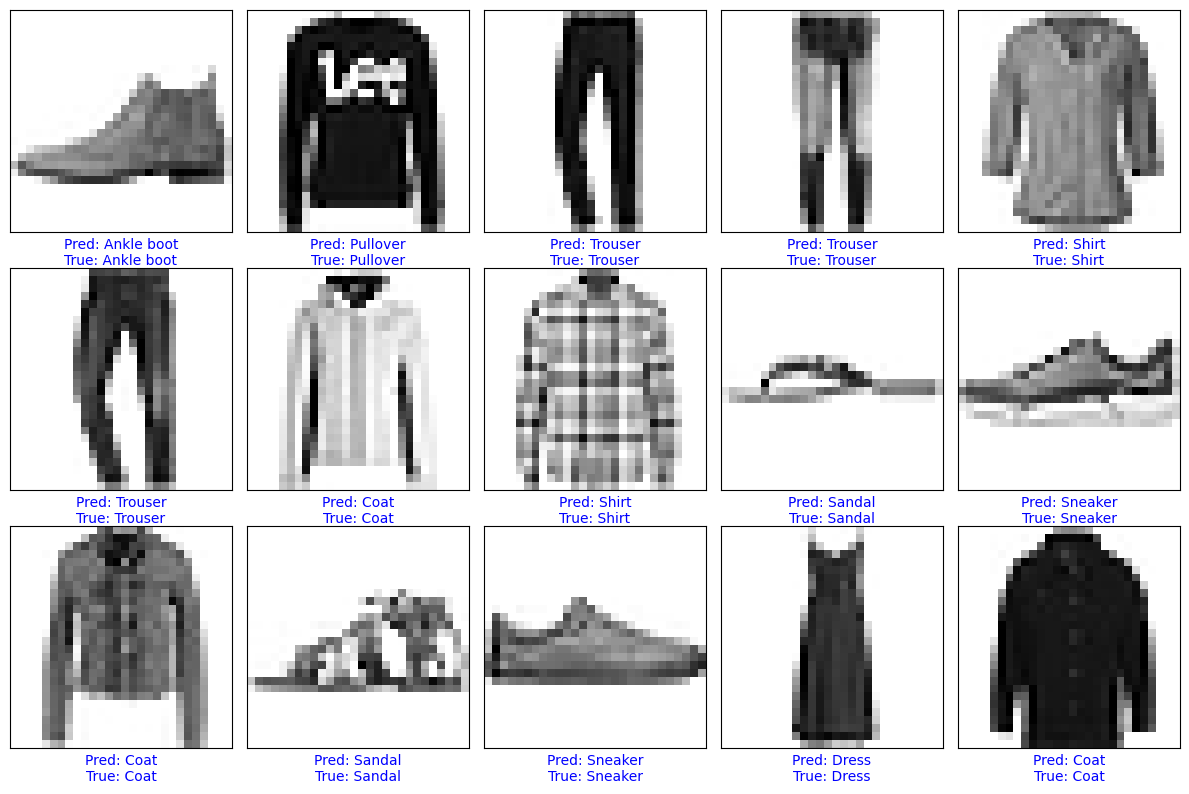

In [24]:
X_new = X_test[:15]
y_proba = model.predict(X_new)
y_pred = np.argmax(y_proba, axis=1)
y_true = y_test[:15]

plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_new[i], cmap=plt.cm.binary)

    predicted_label = class_names[y_pred[i]]
    true_label = class_names[y_true[i]]

    color = 'blue' if y_pred[i] == y_true[i] else 'red'

    plt.xlabel(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

In [25]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

The class of the function is obtained considering:

In [26]:
y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([9, 2, 1])